#Deep Fake Detection Using Frequency Analysis

## Install Required Libraries

In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib opencv-python scikit-learn scikit-image tensorflow

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from google.colab import drive

## Mount Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Define paths
data_path = '/content/Deep_Fake_Detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Preprocess the Data


In [ ]:
# Load the Excel sheet with labels
import os
labels_df = pd.read_csv(os.path.join(data_path, 'data.csv'))

# Define functions for image processing and frequency analysis
def load_image(image_path):
    """Load and convert image to RGB"""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def extract_frequency_features(image):
    """Extract frequency domain features using FFT"""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Apply FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # Resize to a standard size for consistent feature dimensions
    magnitude_spectrum_resized = resize(magnitude_spectrum, (128, 128), anti_aliasing=True)

    # Flatten the feature matrix
    features = magnitude_spectrum_resized.flatten()

    return features

## Process Image and Extract Features


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage.transform import resize

# Load CSV file
data_path = '/content/Deep_Fake_Detection'
labels_df = pd.read_csv(os.path.join(data_path, 'data.csv'))

# Lists to store features and labels
X = []  # Features
y = []  # Labels (0 for real, 1 for fake)

# Utility: Load and process image
def load_image(image_path):
    """Load and convert an image to RGB format."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not load image at {image_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Utility: Extract frequency domain features
def extract_frequency_features(image):
    """Convert image to grayscale, apply FFT, and return resized magnitude spectrum as features."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if image.ndim == 3 else image
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    """ Resize and flattened"""
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    magnitude_spectrum_resized = resize(magnitude_spectrum, (128, 128), anti_aliasing=True)
    return magnitude_spectrum_resized


##Process Images and Extract Features




In [ ]:
import glob

X = []
y = []

for index, row in labels_df.iterrows():
    image_id = row['images_id']
    label_str = row['label'].lower()

    folder = 'real Images' if label_str == 'real' else 'fake Images'
    label = 0 if label_str == 'real' else 1

    # Use glob to match any extension
    search_path = os.path.join(data_path, folder, image_id + '.*')
    matching_files = glob.glob(search_path)

    if not matching_files:
        print(f"⚠️ File not found: {search_path}")
        continue

    image_path = matching_files[0]  # Take the first match

    image = load_image(image_path)
    if image is not None:
        features = extract_frequency_features(image)
        X.append(features)
        y.append(label)

    if index % 100 == 0 or index == len(labels_df) - 1:
        print(f"✅ Processed {index + 1}/{len(labels_df)} images")

X = np.array(X)
y = np.array(y)

print(f"✅ Total images processed: {len(X)}")
print(f"✅ Feature vector shape: {X.shape}")


✅ Processed 1/1289 images
✅ Processed 101/1289 images
✅ Processed 201/1289 images
✅ Processed 301/1289 images
✅ Processed 401/1289 images
✅ Processed 501/1289 images
✅ Processed 601/1289 images
✅ Processed 701/1289 images
✅ Processed 801/1289 images
✅ Processed 901/1289 images
✅ Processed 1001/1289 images
✅ Processed 1101/1289 images
✅ Processed 1201/1289 images
✅ Processed 1289/1289 images
✅ Total images processed: 1289
✅ Feature vector shape: (1289, 128, 128)


## Split Data and Train a Classifier

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data to 2D for RandomForestClassifier
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))


# Train a simple classifier (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       128
           1       0.77      0.87      0.82       130

    accuracy                           0.80       258
   macro avg       0.81      0.80      0.80       258
weighted avg       0.81      0.80      0.80       258

Confusion Matrix:
[[ 94  34]
 [ 17 113]]


## Visualize Results and Important Features

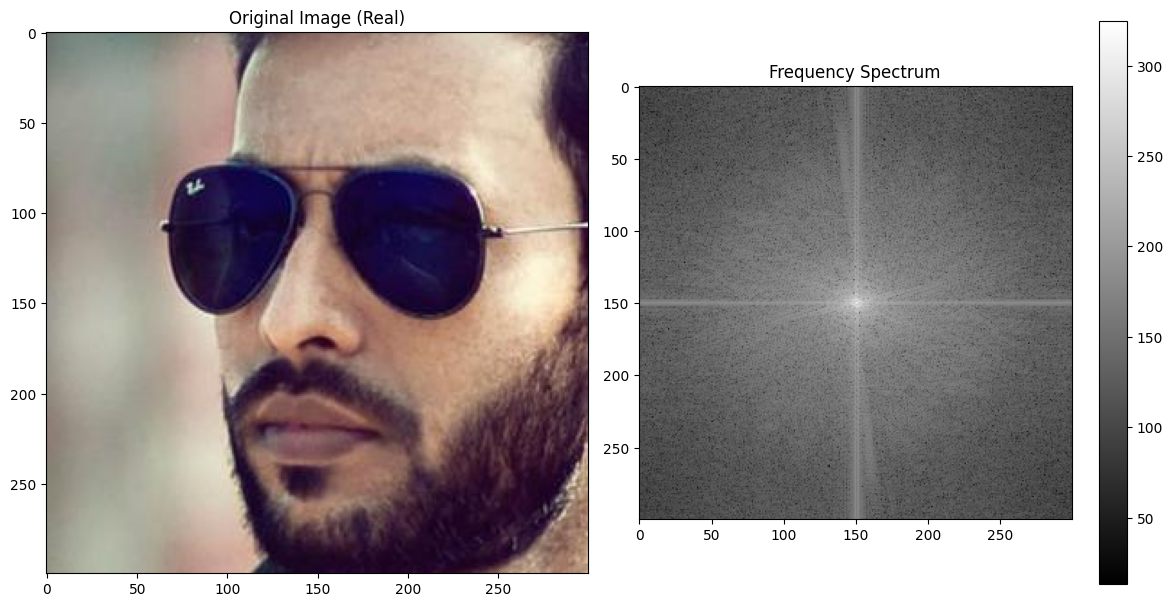

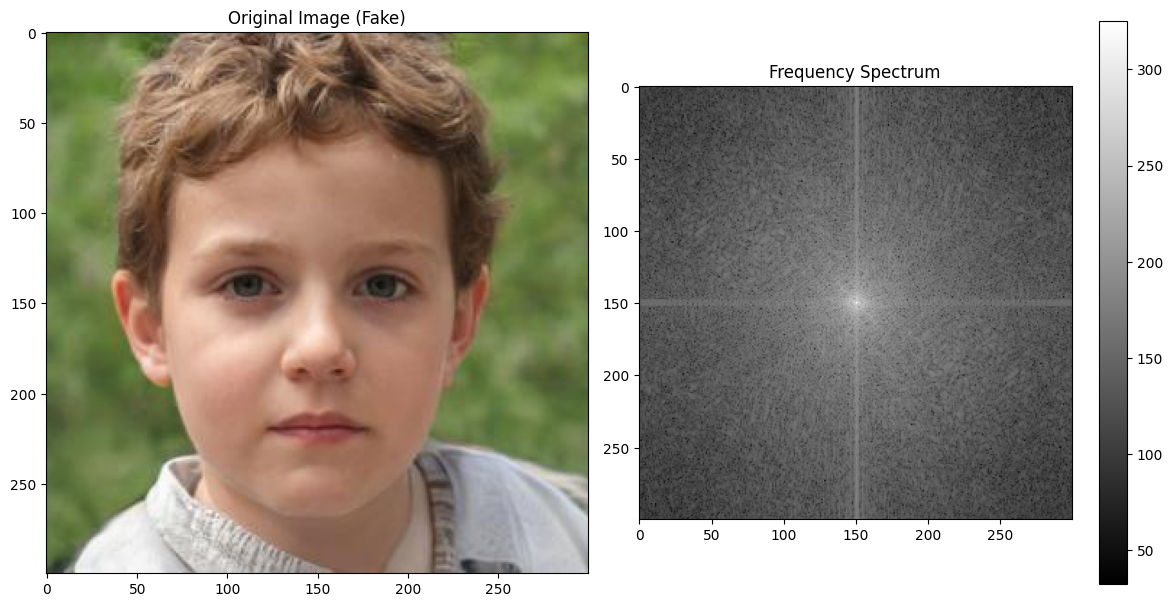

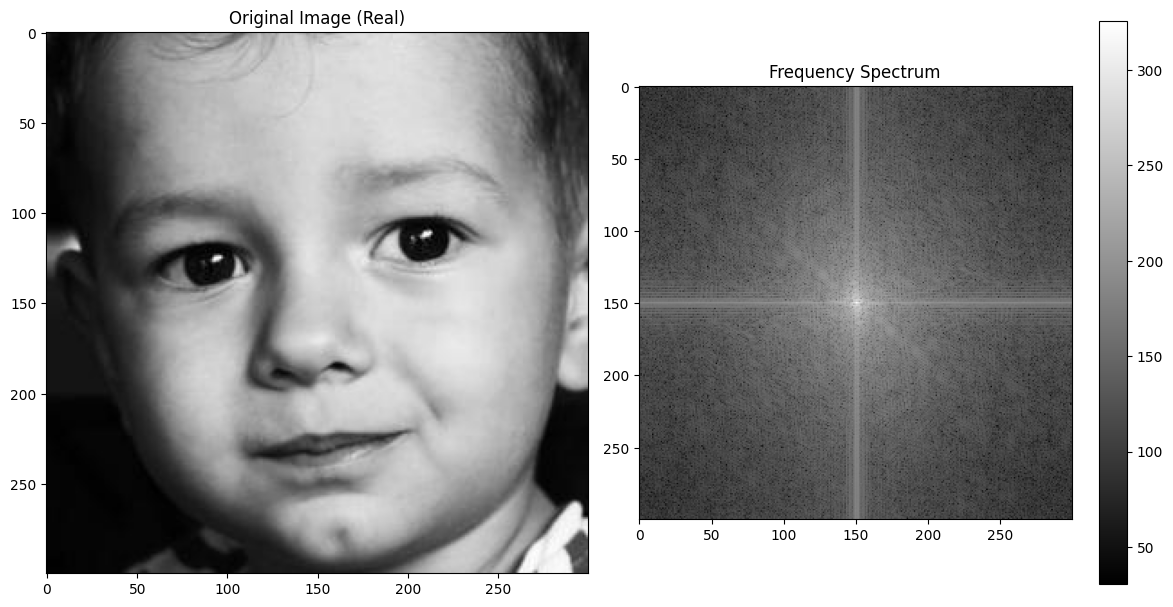

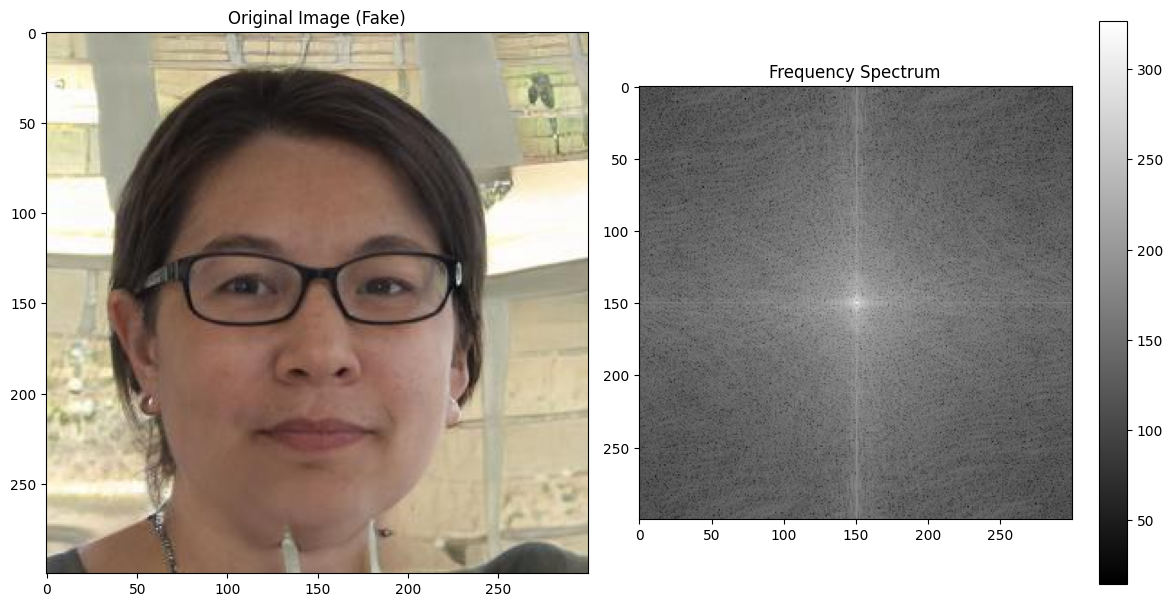

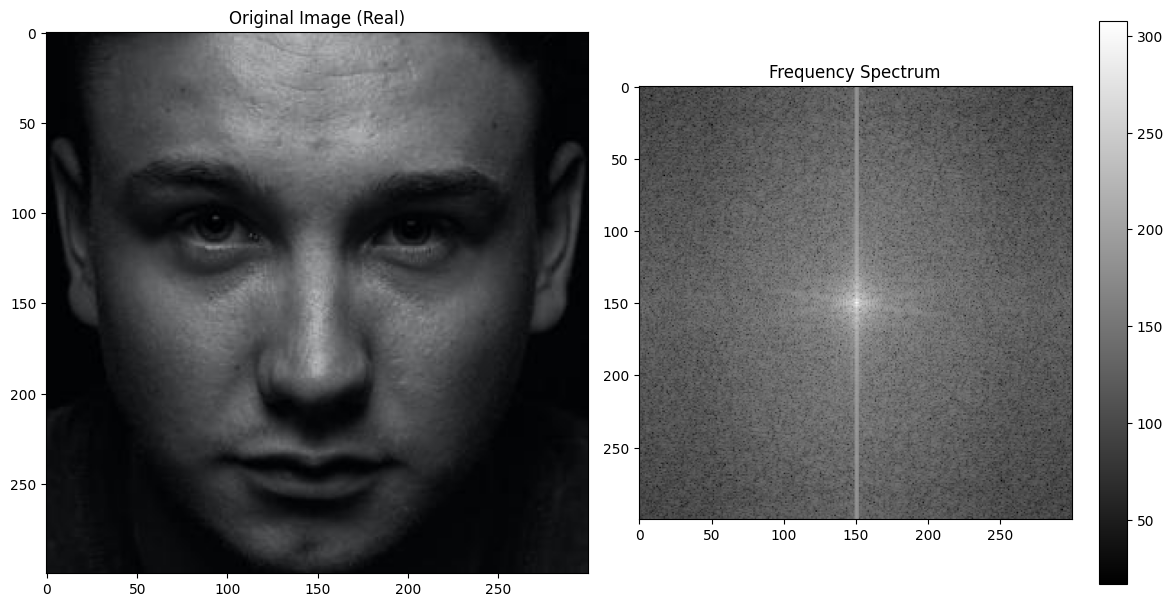

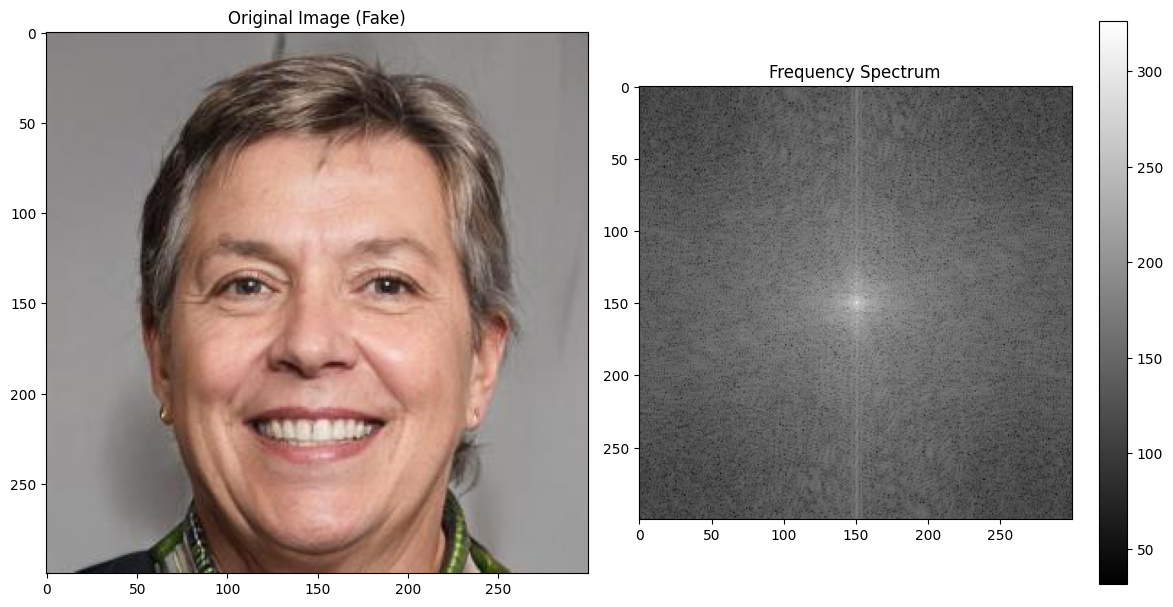

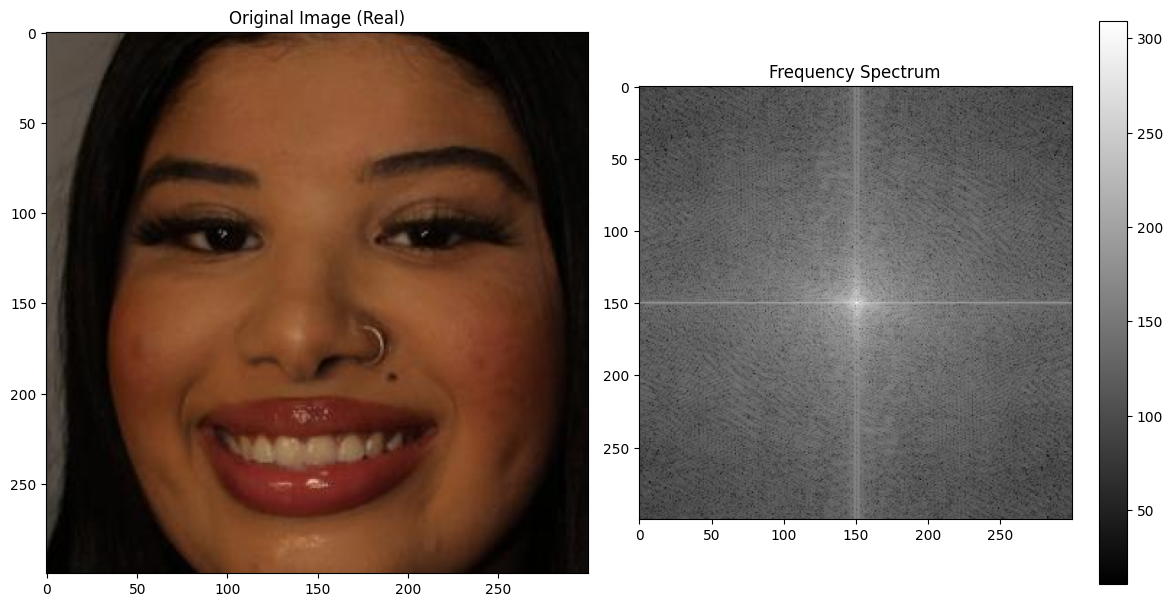

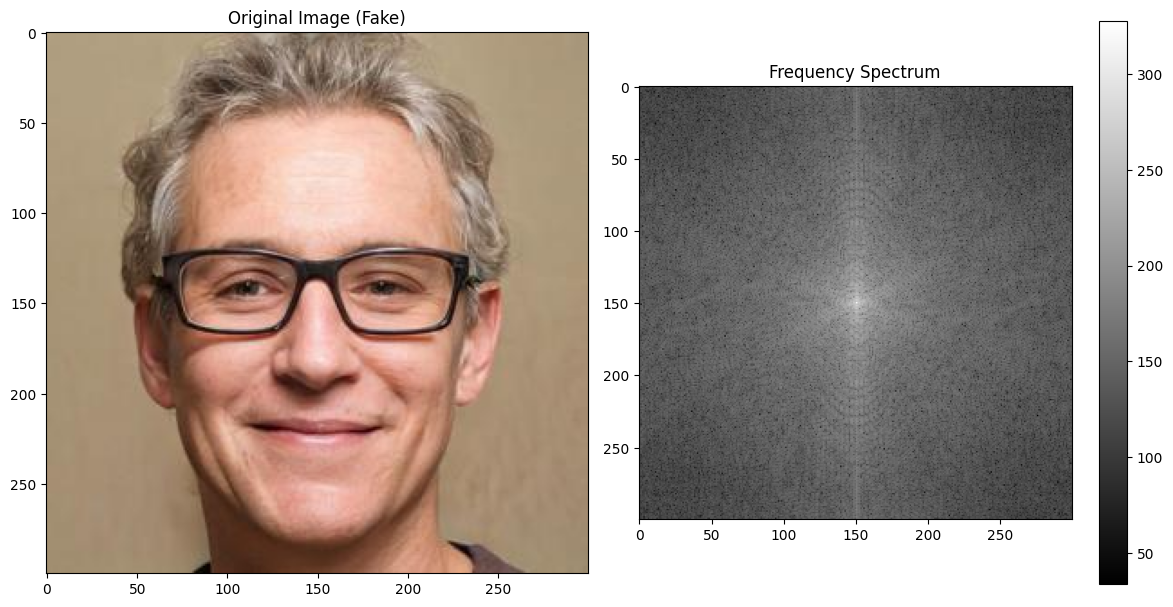

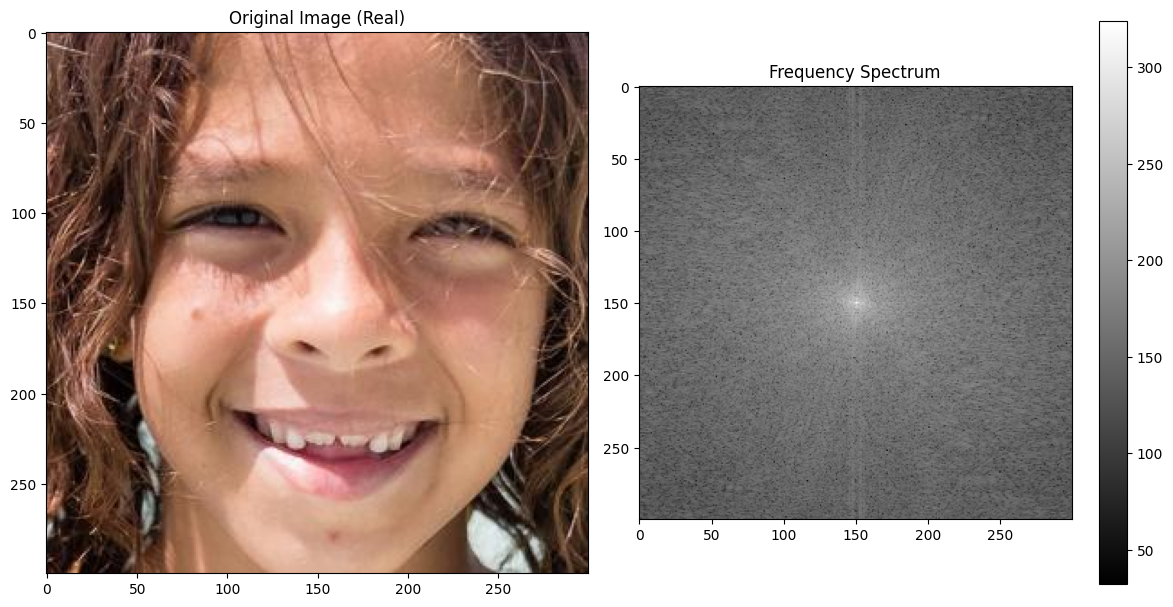

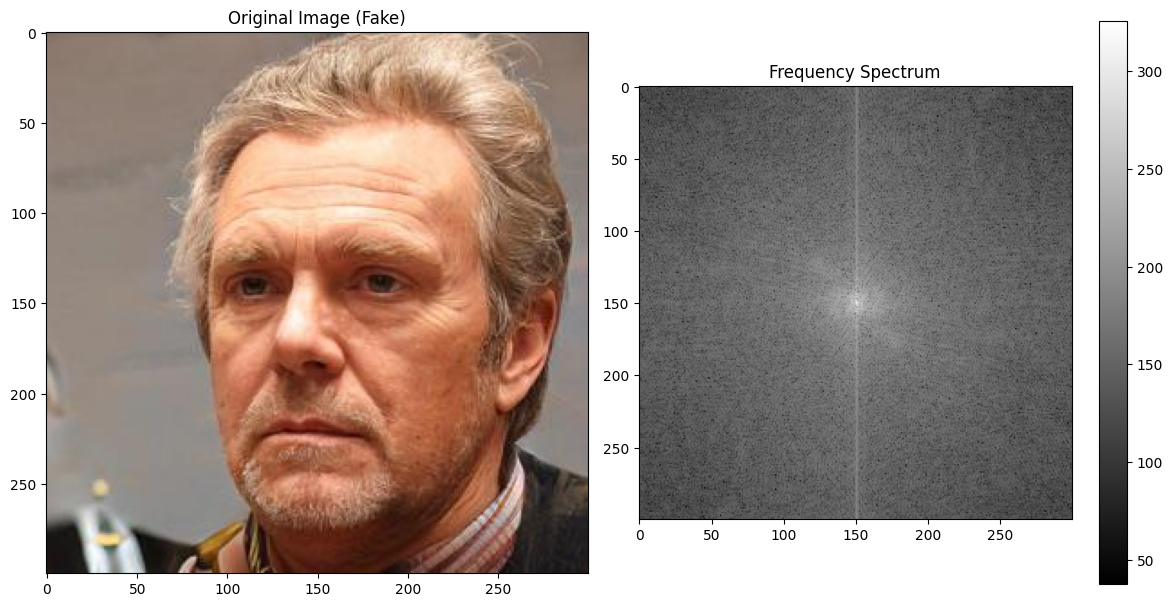

In [ ]:
# Visualize some sample images and their frequency representations
def plot_image_and_spectrum(image_path, is_fake):
    img = load_image(image_path)
    if img is None:
        return

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply FFT
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original Image' + (' (Fake)' if is_fake else ' (Real)'))

    plt.subplot(122)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Spectrum')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# Visualize a few examples
for i in range(5):
    # Get random indices for real and fake samples
    real_idx = np.random.choice(np.where(y == 0)[0])
    fake_idx = np.random.choice(np.where(y == 1)[0])

    # Plot real image
    # The 'image_path' column does not exist; use 'images_id' instead
    # and construct the path using the known folder structure.
    real_image_id = labels_df.iloc[real_idx]['images_id']
    real_path = os.path.join(data_path, 'real Images', real_image_id + '.*')
    real_path = glob.glob(real_path)[0] # Get the actual file path
    plot_image_and_spectrum(real_path, False)

    # Plot fake image
    # The 'image_path' column does not exist; use 'images_id' instead
    # and construct the path using the known folder structure.
    fake_image_id = labels_df.iloc[fake_idx]['images_id']
    fake_path = os.path.join(data_path, 'fake Images', fake_image_id + '.*')
    fake_path = glob.glob(fake_path)[0] # Get the actual file path
    plot_image_and_spectrum(fake_path, True)

 ## Implement a Function to Test New Images

In [ ]:
def predict_image(image_path, model):
    """Predict if an image is real or fake"""
    # Check if path exists
    if not os.path.exists(image_path):
        print(f"Warning: Image path does not exist: {image_path}")
        # Try to suggest alternatives
        parent_dir = os.path.dirname(image_path)
        if os.path.exists(parent_dir):
            print(f"Available files in directory: {os.listdir(parent_dir)[:5]}")
        return "Error: Image file not found"

    # Load and process image
    img = load_image(image_path)
    if img is None:
        return "Error loading image"

    # Extract features
    features = extract_frequency_features(img)

    # Reshape features for prediction
    features = features.reshape(1, -1)

    # Make prediction
    prediction = model.predict(features)[0]

    # Return result
    result = "Fake" if prediction == 1 else "Real"
    return result

# Test the function with images from your existing folders
# First try with a real image
try:
    # Create a directory for test images if it doesn't exist
    test_dir = os.path.join(data_path, 'test_images')
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
        print(f"Created directory: {test_dir}")

    # Get a sample real image from your real_images folder
    real_images_dir = os.path.join(data_path, 'real Images')
    if os.path.exists(real_images_dir) and os.listdir(real_images_dir):
        real_sample = os.path.join(real_images_dir, os.listdir(real_images_dir)[0])
        print(f"Testing with real image: {real_sample}")
        real_result = predict_image(real_sample, model)
        print(f"The real image is predicted to be: {real_result}")

    # Get a sample fake image from your fake_images folder
    fake_images_dir = os.path.join(data_path, 'fake Images')
    if os.path.exists(fake_images_dir) and os.listdir(fake_images_dir):
        fake_sample = os.path.join(fake_images_dir, os.listdir(fake_images_dir)[0])
        print(f"Testing with fake image: {fake_sample}")
        fake_result = predict_image(fake_sample, model)
        print(f"The fake image is predicted to be: {fake_result}")

except Exception as e:
    print(f"Error during testing: {str(e)}")
    print("Available directories in data_path:")
    print(os.listdir(data_path))

Created directory: /content/Deep_Fake_Detection/test_images
Testing with real image: /content/Deep_Fake_Detection/real Images/real_2.jpg
The real image is predicted to be: Real
Testing with fake image: /content/Deep_Fake_Detection/fake Images/fake_7.jpg
The fake image is predicted to be: Fake


## Saving Model

In [ ]:
# Save the trained model
import pickle

# Save to Google Drive or Colab filesystem
model_path = os.path.join(data_path, 'deepfake_detector_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_path}")

Model saved to /content/Deep_Fake_Detection/deepfake_detector_model.pkl
